## **PCA of Molecular Descriptors**
This workflow loads curated SMILES, computes a minimal set of interpretable descriptors (Drug type + O/N counts), standardizes features, performs PCA, and visualizes the first two components. Finally, export per-dataset views.

### **1. Notebook and data preparation**
#### **1.1. Configure the environment**

In [ ]:
### Import necessary libraries and configure settings

import os
import random
from pathlib import Path

import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Descriptors

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.express as px
from plotly import io as pio

In [5]:
### Define parameters and paths for reproducibility and portability

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

INPUT_CSV = "../raw_data/dbs_curated_sidas_dianat.csv" # Path to the curated SMILES CSV
OUTPUT_DIR = Path("../results/outputs_pca") # Directory to save outputs
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

COL_ID = "ID"
COL_DATASET = "DATASET"
COL_SMILES = "curated_smiles"

#### **1.2. Load data and basic sanity checks**
Keep only the required columns and drop rows with missing/invalid SMILES.

In [6]:
### Load data and keep required columns
df = pd.read_csv(INPUT_CSV)

required_cols = [COL_ID, COL_DATASET, COL_SMILES]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in input CSV: {missing}")

df = df[required_cols].copy()
print(df.shape)
df.head(3)

(612, 3)


,ID,DATASET,curated_smiles
0,DiaNatDB-1,DiaNat-DB,O=C(O)C1=C[C@@H](O)[C@@H](O)[C@H](O)C1
1,DiaNatDB-10,DiaNat-DB,C=C(C)[C@@H]1CC[C@]2(C)CC[C@]3(C)[C@H](CC[C@@H...
2,DiaNatDB-100,DiaNat-DB,C=C(CC[C@@H](C)[C@H]1CC[C@@]2(C)C3CC[C@H]4C(C)...


In [7]:
### Validate SMILES and filter invalid rows
def is_valid_smiles(smiles: str) -> bool:
    """
    Return True if SMILES parses into a valid RDKit Mol, else False.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except Exception:
        return False
    
mask_valid = df[COL_SMILES].notna() & df[COL_SMILES].astype(str).apply(is_valid_smiles)
df = df[mask_valid].reset_index(drop=True)
print(f"After filtering invalid SMILES: {df.shape}")
df.head(3)

After filtering invalid SMILES: (612, 3)


,ID,DATASET,curated_smiles
0,DiaNatDB-1,DiaNat-DB,O=C(O)C1=C[C@@H](O)[C@@H](O)[C@H](O)C1
1,DiaNatDB-10,DiaNat-DB,C=C(C)[C@@H]1CC[C@]2(C)CC[C@]3(C)[C@H](CC[C@@H...
2,DiaNatDB-100,DiaNat-DB,C=C(CC[C@@H](C)[C@H]1CC[C@@]2(C)C3CC[C@H]4C(C)...


### **2. Compute descriptor set**
Compute a compact set of physicochemical descriptors commonly used in drug discovery: HBD, HBA, MolWt, logP, TPSA, and Rotatable Bonds, and counts of O and N atoms.

In [10]:
### Define the descriptor columns name
DESC_COLS = ['HBD', 'HBA', 'MolWt', 'LogP', 'TPSA',
            'NumRotatableBonds', 'NumOxygens', 'NumNitrogens']

### Function to compute descriptors
def compute_descriptors(smiles: str) -> pd.Series:
    """
    Compute a set of interpretable molecular descriptors from a SMILES string.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return pd.Series([np.nan] * len(DESC_COLS), index=DESC_COLS)
    
    return pd.Series([
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == '8'),
        sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == '7')
    ], index=DESC_COLS)

In [17]:
### Apply per-row descriptor computation
df_desc = df[COL_SMILES].astype(str).apply(compute_descriptors)
df_final = pd.concat([df, df_desc], axis=1)

descriptors_csv = OUTPUT_DIR/"sidas_dianat_descriptors.csv"
df_final.to_csv(descriptors_csv, index=False)
print(f"Saved: {descriptors_csv}")

print(f"After computing descriptors: {df_final.shape}")
df_final.head(3)

Saved: ../results/outputs_pca/sidas_dianat_descriptors.csv
After computing descriptors: (612, 11)


,ID,DATASET,curated_smiles,HBD,HBA,MolWt,LogP,TPSA,NumRotatableBonds,NumOxygens,NumNitrogens
0,DiaNatDB-1,DiaNat-DB,O=C(O)C1=C[C@@H](O)[C@@H](O)[C@H](O)C1,4.0,4.0,174.152,-1.5162,97.99,1.0,0.0,0.0
1,DiaNatDB-10,DiaNat-DB,C=C(C)[C@@H]1CC[C@]2(C)CC[C@]3(C)[C@H](CC[C@@H...,1.0,1.0,426.729,8.0248,20.23,1.0,0.0,0.0
2,DiaNatDB-100,DiaNat-DB,C=C(CC[C@@H](C)[C@H]1CC[C@@]2(C)C3CC[C@H]4C(C)...,1.0,1.0,440.756,8.4149,20.23,5.0,0.0,0.0


### **3. PCA workflow overview**

* Select only descriptor columns.
* Standardize features (mean 0, variance 1).
* Fit PCA and compute transformed components.
* Inspect explained variance and visualize PC2 vs. PC1.

#### **3.1 Build the feature matrix and labels**

In [21]:
feature_matrix = df_final[DESC_COLS].to_numpy(dtype=float) # Feature matrix for PCA
labels = df_final[[COL_DATASET, COL_ID, COL_SMILES]].copy()  # Labels for reference

print(f"Feature matrix shape: {feature_matrix.shape}")

pd.DataFrame(feature_matrix).head(3)

Feature matrix shape: (612, 8)


,0,1,2,3,4,5,6,7
0,4.0,4.0,174.152,-1.5162,97.99,1.0,0.0,0.0
1,1.0,1.0,426.729,8.0248,20.23,1.0,0.0,0.0
2,1.0,1.0,440.756,8.4149,20.23,5.0,0.0,0.0


#### **3.2. Standardize and fit PCA**
Standardize features before PCA. Compute the first 3 components for potential 3D use and a full PCA for variance plots.

In [22]:
### Standardize and fit PCA
scaler = StandardScaler()
feature_matrix_std = scaler.fit_transform(feature_matrix)

pca_3d = PCA(n_components=3, random_state=SEED)
components_3d = pca_3d.fit_transform(feature_matrix_std)

In [26]:
### Assemble a PCA results DataFrame
pca_3d_df = labels.copy()
pca_3d_df[['PC1', 'PC2', 'PC3']] = components_3d

pca_3d_csv = OUTPUT_DIR/"sidas_dianat_pca_3d.csv"
pca_3d_df.to_csv(pca_3d_csv, index=False)
print(f"Saved: {pca_3d_csv}")
print(pca_3d_df.shape)
pca_3d_df.head(3)

Saved: ../results/outputs_pca/sidas_dianat_pca_3d.csv
(612, 6)


,DATASET,ID,curated_smiles,PC1,PC2,PC3
0,DiaNat-DB,DiaNatDB-1,O=C(O)C1=C[C@@H](O)[C@@H](O)[C@H](O)C1,-0.672887,-1.737184,0.416677
1,DiaNat-DB,DiaNatDB-10,C=C(C)[C@@H]1CC[C@]2(C)CC[C@]3(C)[C@H](CC[C@@H...,-2.109580,1.320053,-1.478001
2,DiaNat-DB,DiaNatDB-100,C=C(CC[C@@H](C)[C@H]1CC[C@@]2(C)C3CC[C@H]4C(C)...,-1.900804,2.016830,-0.802371


#### **3.3. Explained variance (individual and cumulative plots)**
Compute explained variance ratios for all components to decide how many PCs are enough informative.

PC1 variance: 63.882524%
PC2 variance: 23.423279%


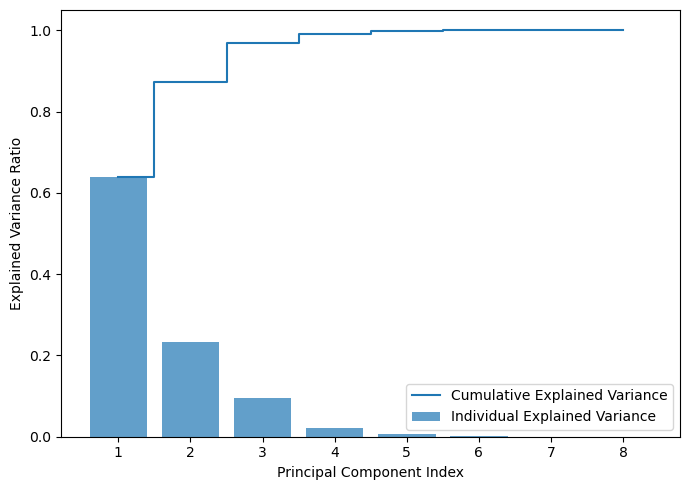

In [28]:
### Scree (individual) and cumulative variance plots
pca_full = PCA(random_state=SEED)
pca_full.fit(feature_matrix_std)

exp_var = pca_full.explained_variance_ratio_
cum_exp_var = np.cumsum(exp_var)

plt.figure(figsize=(7, 5))
plt.bar(range(1, len(exp_var) + 1), exp_var, alpha=0.7, label='Individual Explained Variance')
plt.step(range(1, len(cum_exp_var) + 1), cum_exp_var, where='mid', label='Cumulative Explained Variance')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(OUTPUT_DIR/"sidas_dianat_pca_explained_variance.png", dpi=300)
print(f"PC1 variance: {exp_var[0]*100:2f}%")
print(f"PC2 variance: {exp_var[1]*100:2f}%")
plt.show()

Al realizar el método de PCA, hay una pérdida de correlación con cada componente, por esto es necesario poder identificar la cantidad de correlación que poseemos para nuestras representaciones visuales, pudiendo determinar si estas serán relevantes o no por la cantidad de correlación que posean con la muestra original.

Finalmente, se pretende visualizar la varianza explicada por cada componente principal utilizando una gráfica de barras y una gráfica escalonada. La variable "cum_sum_eigenvalues" es un arreglo numpy que contiene la suma acumulativa de la varianza explicada por cada componente principal. Luego, se utiliza la función "plt.bar()" para crear la gráfica de barras de la varianza explicada para cada componente principal y la función "plt.step()" para crear la gráfica escalonada de la varianza explicada acumulada. Finalmente, se ajustan los ejes y se muestran ambas gráficas utilizando "plt.tight_layout()" y "plt.show()".

### **4. Interactive PCA scatter**
Points are colored by dataset. Hover to see ID and SMILES. Axis titles include the actual explained variance.

In [42]:
### Color dataset values
COLOR_MAP = {
    'DiaNat-DB': "#979745",
    'SH-accumulated': "#4AB82B",
    'SG-accumulated': "#304be3",
    'SR-accumulated': "#19a3a6"
    }

In [45]:
list(COLOR_MAP.values())

['#979745', '#4AB82B', '#304be3', '#19a3a6']

In [46]:
### Color dataset values
COLOR_MAP = {
    'DiaNat-DB': "#979745",
    'SH-accumulated': "#4AB82B",
    'SG-accumulated': "#304be3",
    'SR-accumulated': "#19a3a6"
            }

### Interactive Plotly PCA scatter
fig_pca = px.scatter(
    pca_3d_df, x='PC1', y='PC2',
    color=COL_DATASET,
    color_discrete_sequence=list(COLOR_MAP.values()),
    title=False,
    hover_data=[COL_ID],
    width=1000,
    height=800)

### Improve layout and axis titles with dynamic variance
fig_pca.update_traces(marker=dict(size=10))
fig_pca.update_layout(
    xaxis=dict(
        showgrid=False, showline=True, linewidth=1, linecolor='black', mirror=True
    ),
    yaxis=dict(
        showgrid=False, showline=True, linewidth=1, linecolor='black', mirror=True
    ),
    plot_bgcolor='white', paper_bgcolor='white',
    showlegend=True
)
fig_pca.update_xaxes(
    title_text=f"Principal component 1 ({exp_var[0]*100:.2f}%)",
    range=[-5, 10],
    title_font=dict(size=20, color= "black")
)
fig_pca.update_yaxes(
    title_text=f"Principal component 2 ({exp_var[1]*100:.2f}%)",
    range=[-4, 8],
    title_font=dict(size=20, color= "black")
)

### Save the static PNG
png_all = OUTPUT_DIR/"sidas_dianat_pca_all.png"
pio.write_image(fig_pca, str(png_all), width=1000, height=800, scale=3)
print(f"Saved: {png_all}")
fig_pca.show()

Saved: ../results/outputs_pca/sidas_dianat_pca_all.png


### **5. Individual PCA scatter plots**
Filter the PCA dataframe to visualize and export a single dataset, reusing the styling.

In [47]:
### Existing datasets in the PCA results
print("Datasets found:", set(pca_3d_df[COL_DATASET]))

Datasets found: {'DiaNat-DB', 'SH-accumulated', 'SG-accumulated', 'SR-accumulated'}


In [ ]:
### Iterate through datasets and create individual plots
for dataset in sorted(set(pca_3d_df[COL_DATASET])):
    ### Filter PCA results for the specific dataset
    pca_dataset = pca_3d_df[pca_3d_df[COL_DATASET] == dataset].copy()
    
    ### Get the corresponding color from the COLOR_MAP
    color_value = COLOR_MAP.get(dataset, "#000000")  # Default to black if not found
    
    ### Create the scatter plot for the individual dataset
    fig_individual = px.scatter(
        pca_dataset, x='PC1', y='PC2',
        color_discrete_sequence=[color_value],
        title=False,
        hover_data=[COL_ID],
        width=1000, height=800)
    
    ### Improve layout and axis titles with dynamic variance
    fig_individual.update_traces(marker=dict(size=10))
    fig_individual.update_layout(
        xaxis=dict(
        showgrid=False, showline=True, linewidth=1, linecolor='black', mirror=True
        ),
        yaxis=dict(
        showgrid=False, showline=True, linewidth=1, linecolor='black', mirror=True
        ),
        plot_bgcolor='white', paper_bgcolor='white',
        showlegend=False
    )
    fig_individual.update_xaxes(
        title_text=f'Principal component 1',
        range=[-5, 10],
        title_font=dict(size=20, color= "black")
    )
    fig_individual.update_yaxes(
        title_text=f'Principal component 2',
        range=[-4, 8],
        title_font=dict(size=20, color= "black")
    )
    
    ### Save the static PNG
    png_individual = OUTPUT_DIR/f"sidas_dianat_pca_{dataset.lower()}.png"
    pio.write_image(fig_individual, str(png_individual), width=1000, height=800, scale=3)
    print(f"Saved: {png_individual}")
    fig_individual.show()